In [8]:
import torch
from matplotlib import pyplot as plt

from torch_cubic_b_spline_grid import CubicBSplineGrid1d

some variables we can set...

In [9]:
N_CONTROL_POINTS = 6
N_OBSERVATIONS_PER_ITERATION = 20

initialise our optimisable parameters, a 1D grid of `N_CONTROL_POINTS` uniformly spaced
points

In [10]:
grid_1d = CubicBSplineGrid1d(resolution=N_CONTROL_POINTS)

define a function for making observations over the interval `[0, 1]` covering our 1d
grid

In [11]:
def make_observations(n, add_noise: bool = False):
    x = torch.rand(n)  # in range [0, 1]
    y = torch.sin(2 * torch.pi * x)
    if add_noise is True:
        y += torch.normal(torch.zeros(n), std=0.5)
    return x, y

initialise the optimiser

In [12]:
optimiser = torch.optim.SGD(grid_1d.parameters(), lr=0.02)

optimise the values at the control points such that interpolating between them with
cubic B-spline interpolation fits the data

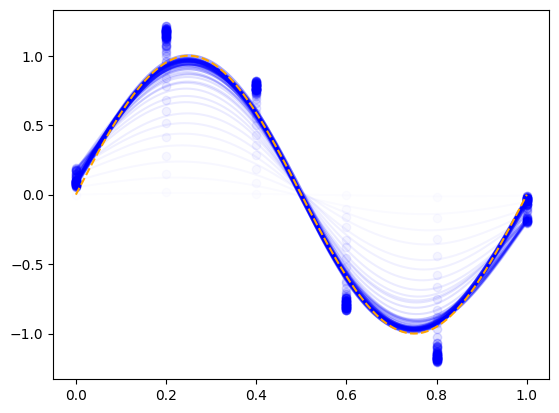

In [13]:
# some plotting stuff
fig, ax = plt.subplots()
control_point_x = torch.linspace(0, 1, N_CONTROL_POINTS)
decay = 1
ax.scatter(control_point_x, grid_1d.data, color='white')

# actually optimising!
for i in range(500):
    # make (noisy) observations of the data we want to model
    x, y = make_observations(N_OBSERVATIONS_PER_ITERATION, add_noise=True)

    # what does the model predict for our observations?
    prediction = grid_1d(x).squeeze()

    # zero gradients and calculate loss between observations and model prediction
    optimiser.zero_grad()
    loss = torch.sum((prediction - y)**2)**0.5

    # backpropagate loss and update values at points on grid
    loss.backward()
    optimiser.step()

    # plot
    if i % 10 == 0:
        decay *= 0.99
        ax.scatter(control_point_x, grid_1d.data, color='blue', alpha=1 - decay)

        x = torch.linspace(0, 1, 1000)
        y = grid_1d(x).squeeze()
        ax.plot(x, y.detach(), alpha=1 - decay, color='blue')

x = torch.linspace(0, 1, 1000)
y = torch.sin(x * 2 * torch.pi)
ax.plot(x, y, ls='--', color='orange')

this model has very little capacity to overfit to noisy data because of the small
number of points on our grid (parameters)